**Define parameters**

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)

# Define simulation parameters
replications = 1000  # Number of Monte Carlo repetitions
sample_sizes = [25, 50, 100, 250, 500, 1000]  # Sample sizes considered
beta_true = np.array([1, 1, 1, 1, 0])  # True regression coefficients (including intercept)
p = len(beta_true)  # Number of parameters (5 in this case)

# Store rejection rates for different methods
reject_rate = {method: {j: [] for j in range(1, p)}  # We ignore the intercept (index 0)
               for method in ['OLS', 'HC0', 'HC1', 'HC2', 'HC3']}

**Define critical t value fuction**

In [38]:
from math import sqrt
def t_critical(df, alpha=0.05):
    # Approximate critical value for a two-tailed t-test at 5% significance level
    return 1.96 if df > 80 else 1.98  # For small sample sizes, adjust slightly

**Monte Carlo simulation**

In [39]:
# Main loop over different sample sizes
for N in sample_sizes:
    df = N - p  # Degrees of freedom
    tcrit = t_critical(df)  # Critical t-value

    # Initialize rejection count
    count_reject = {method: {j: 0 for j in range(1, p)} for method in ['OLS', 'HC0', 'HC1', 'HC2', 'HC3']}

    # Perform Monte Carlo simulations
    for r in range(replications):
        # Step 1: Generate independent variables
        X0 = np.ones(N)  # Intercept
        X1 = np.random.normal(0, 1, N)
        X2 = np.random.uniform(0, 1, N)
        X3 = np.random.uniform(0, 1, N)
        X4 = np.random.binomial(1, 0.5, N)
        X = np.column_stack((X0, X1, X2, X3, X4))

        # Step 2: Generate heteroskedastic error term
        e_base = np.random.chisquare(df=5, size=N)  # χ²₅ errors
        e_base = (e_base - 5) / sqrt(10)  # Centering and normalizing
        tau = 0.75  # Scaling factor
        error = tau * np.sqrt(X3 + 1.6) * e_base  # Heteroskedastic errors

        # Compute dependent variable
        Y = X.dot(beta_true) + error

        # Step 3: Compute OLS estimates
        XtX = X.T.dot(X)
        XtX_inv = np.linalg.inv(XtX)
        beta_hat = XtX_inv.dot(X.T.dot(Y))
        residuals = Y - X.dot(beta_hat)

        # Compute standard errors
        RSS = residuals.T.dot(residuals)
        sigma2_hat = RSS / df
        cov_OLS = sigma2_hat * XtX_inv
        se_OLS = np.sqrt(np.diag(cov_OLS))

        # Compute robust standard errors (HC0, HC1, HC2, HC3)
        h = np.einsum('ij,jk,ik->i', X, XtX_inv, X)
        u2 = residuals**2

        # HC0
        A0 = X.T.dot(u2[:, None] * X)
        cov_HC0 = XtX_inv.dot(A0).dot(XtX_inv)
        se_HC0 = np.sqrt(np.diag(cov_HC0))

        # HC1
        cov_HC1 = (N / (N - p)) * cov_HC0
        se_HC1 = np.sqrt(np.diag(cov_HC1))

        # HC2
        w2 = u2 / (1 - h)
        A2 = X.T.dot(w2[:, None] * X)
        cov_HC2 = XtX_inv.dot(A2).dot(XtX_inv)
        se_HC2 = np.sqrt(np.diag(cov_HC2))

        # HC3
        w3 = u2 / ((1 - h)**2)
        A3 = X.T.dot(w3[:, None] * X)
        cov_HC3 = XtX_inv.dot(A3).dot(XtX_inv)
        se_HC3 = np.sqrt(np.diag(cov_HC3))

        # Step 4: Perform t-tests and record rejection rates
        for j in range(1, p):
            true_val = beta_true[j]

            for method, se in zip(['OLS', 'HC0', 'HC1', 'HC2', 'HC3'],
                                  [se_OLS, se_HC0, se_HC1, se_HC2, se_HC3]):
                t_stat = (beta_hat[j] - true_val) / se[j]
                if abs(t_stat) > tcrit:
                    count_reject[method][j] += 1

    # Store rejection rates
    for method in reject_rate.keys():
        for j in range(1, p):
            reject_rate[method][j].append(count_reject[method][j] / replications)

**Convert Results into Arrays**

In [40]:
methods = ['OLS', 'HC0', 'HC1', 'HC2', 'HC3']
coef_index = [1, 2, 3, 4]
reject_rate_array = {method: np.array([reject_rate[method][j] for j in coef_index]) 
                     for method in methods}

**Plot Empirical Size for Each Coefficient**

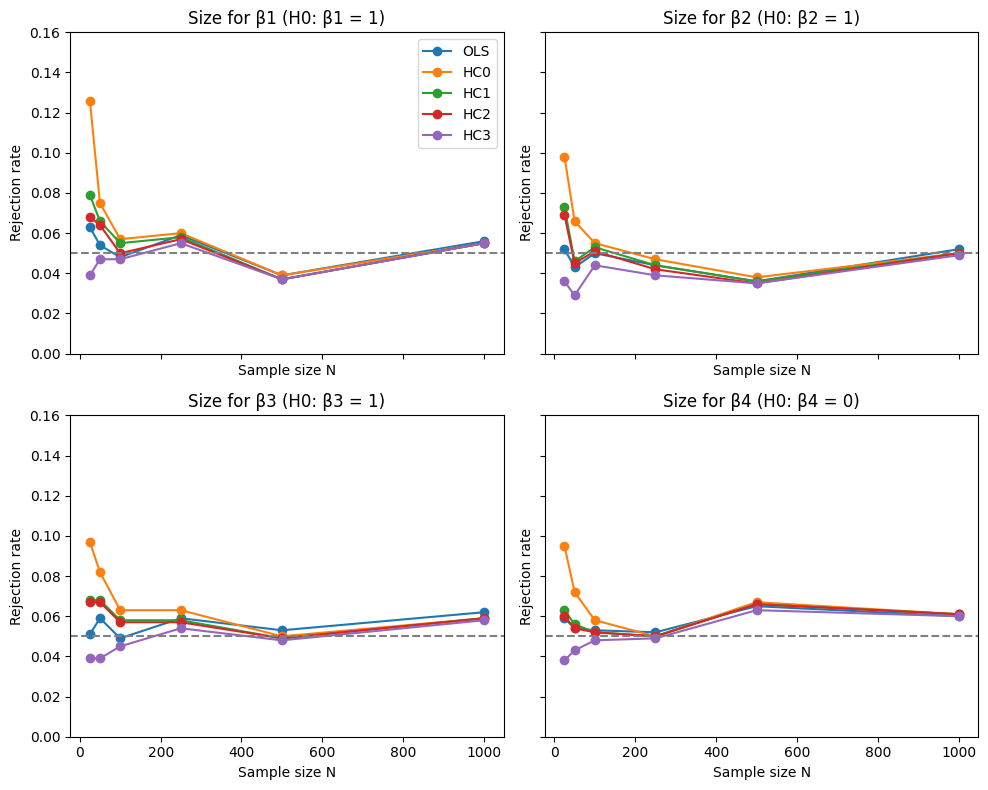

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)
axes = axes.flatten()
for idx, j in enumerate(coef_index):
    ax = axes[idx]
    for method in methods:
        ax.plot(sample_sizes, reject_rate_array[method][j-1, :], marker='o', label=method if idx==0 else "")
    ax.axhline(0.05, color='gray', linestyle='--')
    ax.set_title(f"Size for β{j} (H0: β{j} = {beta_true[j]})")
    ax.set_xlabel("Sample size N")
    ax.set_ylabel("Rejection rate")
    ax.set_ylim(0, 0.16)
axes[0].legend(loc='upper right')
plt.tight_layout()
plt.show()